# Stock Price Prediction avec LSTM

**LSTM (Long Short-Term Memory)** est une architecture de réseau neuronal récurrent artificiel (RNN) utilisée dans le deep learning.
Les LSTM sont largement utilisés pour les problèmes de prédiction de séquences et se sont avérés extrêmement efficaces. La raison pour laquelle ils fonctionnent si bien, c’est parce que LSTM est en mesure de stocker des informations passées qui est important, et oublier l’information qui n’est pas.

## Importer les libraries

In [1]:
#pip install yfinance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
from keras.models import Sequential
from keras.layers import LSTM,Dense
from keras.models import load_model
%matplotlib inline
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

C:\Users\ouizb\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ouizb\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ouizb\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ouizb\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.

## Historique des cours de  Microsoft, AMazon et Google

Historique des prix par jour sur les dix dernières années en utilisant Yahoo's Finance API. 

In [2]:
def get_data(symbol):
    tickerData = yf.Ticker(symbol)
    data = tickerData.history(period='1d', start='2010-10-1', end="2020-10-2")
    data['companies'] = symbol
    data.drop(['Dividends', 'Stock Splits'], axis=1, inplace=True)
    return data



In [3]:
msft = get_data("MSFT")
amzn = get_data("AMZN")
goog = get_data("GOOG")

In [4]:
msft.tail()

,Open,High,Low,Close,Volume,companies
Date,,,,,,
2020-09-25,203.55,209.04,202.54,207.82,29437300,MSFT
2020-09-28,210.88,212.57,208.06,209.44,32004900,MSFT
2020-09-29,209.35,210.07,206.81,207.26,24221900,MSFT
2020-09-30,207.73,211.98,206.54,210.33,33780700,MSFT
2020-10-01,213.49,213.99,211.32,212.46,27158400,MSFT


##  Concaténer les 3 Dataframes

Nous avons 7557 observations et 6 features

In [5]:
company_list = [msft, amzn, goog]
    
df_concat = pd.concat(company_list, axis=0)
    
df_concat.head()

,Open,High,Low,Close,Volume,companies
Date,,,,,,
2010-09-30,19.50,19.67,19.30,19.40,61262700,MSFT
2010-10-01,19.62,19.66,19.25,19.32,62672300,MSFT
2010-10-04,18.98,19.01,18.84,18.94,98143400,MSFT
2010-10-05,19.06,19.37,18.94,19.29,78152900,MSFT
2010-10-06,19.27,19.44,19.12,19.36,50489700,MSFT


In [6]:
df_concat.companies.unique()

array(['MSFT', 'AMZN', 'GOOG'], dtype=object)

## Split data 

1. Nous choisissons uniquement closing prices puis nous les convertissons en un array. 

2. Split des données training dataset(80%) et test 

3. Nous utilisons MinMaxScaler pour avoir des valeurs comprises entre 0 et 1.  

4. Créons un data training composé des 60 derniers jours, que nous utiliserons à la fin  pour prédire la valeur du prix de clôture 61e.
5. Reshape les données pour qu’elles soient tridimensionnelles afin de les mettre dans le modèle LSTM

In [7]:
def split_data(df, symbol):
    data = df.filter(['Close']).loc[df['companies']== symbol]
    dataset = data.values.reshape(-1, 1)
    training_data_len = int(np.ceil(len(dataset) * .8 ))
    print(f'Longueur du data: {training_data_len}')
    print('================================================')
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data= scaler.fit_transform(dataset)
    train_data = scaled_data[0:int(training_data_len), :]
    x_train = []
    y_train = []
    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    test_data = scaled_data[training_data_len - 60: , :]
    x_test = []
    y_test = dataset[training_data_len:, :]
    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))
    return x_train, y_train, x_test, y_test, scaler, data, dataset, training_data_len

## Construction de modèle LSTM 

1. **ModelCheckpoint** va enregistrer les poids des modèles à la fin de chaque époque
2. **CSVLogger** va sauvegarder nos RMSE
3. Splittons une partie des données tranining en validation
4. plot history RMSE
5. VIsualization des valeurs actuelles vs Prédictions

In [8]:
def algo_lstm(x_train, y_train, x_test, y_test, scaler, symbol):
    x_train, y_train, x_test, y_test, scaler, data, dataset, training_data_len = split_data(df_concat, "MSFT")
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape= (x_train.shape[1], 1)))
    model.add(LSTM(50, return_sequences= False))
    model.add(Dense(25))
    model.add(Dense(1))
    checkpointer = ModelCheckpoint(filepath=f"{symbol}_model.h5", verbose=1, save_best_only=True)
    csv_logger = CSVLogger(f"{symbol}_history_loss.log")
    callbacks=[csv_logger, checkpointer]
    model.compile(optimizer='adam', loss='mean_squared_error')
    history = model.fit(x_train, y_train, batch_size=16, epochs=50, validation_split=0.1, callbacks=[callbacks])

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)

    rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
    print('================================================')
    print(f'RMSE: {rmse}')
    print('================================================')
    train = data[:training_data_len]
    valid = data[training_data_len:]
    valid['Predictions'] = predictions

    plt.figure(figsize=(16,8))
    plt.title('Prédictions vs. valeurs réeles')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close USD ($)', fontsize=18)
    plt.plot(train['Close'])
    plt.plot(valid[['Close', 'Predictions']])
    plt.legend(['Train', 'Valeurs actuelles', 'Prédictions'], loc='lower right')
    plt.show()
    print('================================================')
    print(valid)
    

    return model



# LSTM Microsft

La valeur de notre RMSE est de 5 pour Microsoft. 

In [9]:
 x_train, y_train, x_test, y_test, scaler, data, dataset, training_data_len = split_data(df_concat, "MSFT")

Longueur du data: 2016


Longueur du data: 2016
Epoch 1/50
109/110 [============================>.] - ETA: 0s - loss: 2.9957e-04
Epoch 00001: val_loss improved from inf to 0.00024, saving model to MSFT_model.h5
110/110 [==============================] - 5s 49ms/step - loss: 2.9707e-04 - val_loss: 2.3614e-04
Epoch 2/50
109/110 [============================>.] - ETA: 0s - loss: 3.2360e-05
Epoch 00002: val_loss improved from 0.00024 to 0.00012, saving model to MSFT_model.h5
110/110 [==============================] - 5s 48ms/step - loss: 3.2221e-05 - val_loss: 1.1855e-04
Epoch 3/50
110/110 [==============================] - ETA: 0s - loss: 3.3559e-05
Epoch 00003: val_loss improved from 0.00012 to 0.00009, saving model to MSFT_model.h5
110/110 [==============================] - 5s 49ms/step - loss: 3.3559e-05 - val_loss: 8.6907e-05
Epoch 4/50
109/110 [============================>.] - ETA: 0s - loss: 3.8174e-05
Epoch 00004: val_loss did not improve from 0.00009
110/110 [==============================] - 5s 42ms/ste

110/110 [==============================] - ETA: 0s - loss: 1.0672e-05
Epoch 00034: val_loss did not improve from 0.00004
110/110 [==============================] - 7s 61ms/step - loss: 1.0672e-05 - val_loss: 4.8238e-05
Epoch 35/50
110/110 [==============================] - ETA: 0s - loss: 1.7974e-05
Epoch 00035: val_loss improved from 0.00004 to 0.00004, saving model to MSFT_model.h5
110/110 [==============================] - 6s 55ms/step - loss: 1.7974e-05 - val_loss: 3.9231e-05
Epoch 36/50
110/110 [==============================] - ETA: 0s - loss: 1.0983e-05- ETA: 0s - loss:
Epoch 00036: val_loss did not improve from 0.00004
110/110 [==============================] - 8s 69ms/step - loss: 1.0983e-05 - val_loss: 5.5822e-05
Epoch 37/50
110/110 [==============================] - ETA: 0s - loss: 1.0400e-05
Epoch 00037: val_loss improved from 0.00004 to 0.00004, saving model to MSFT_model.h5
110/110 [==============================] - 7s 64ms/step - loss: 1.0400e-05 - val_loss: 3.8968e-05
E

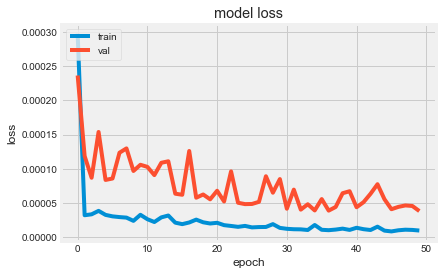

RMSE: 3.4176287599770268


C:\Users\ouizb\anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


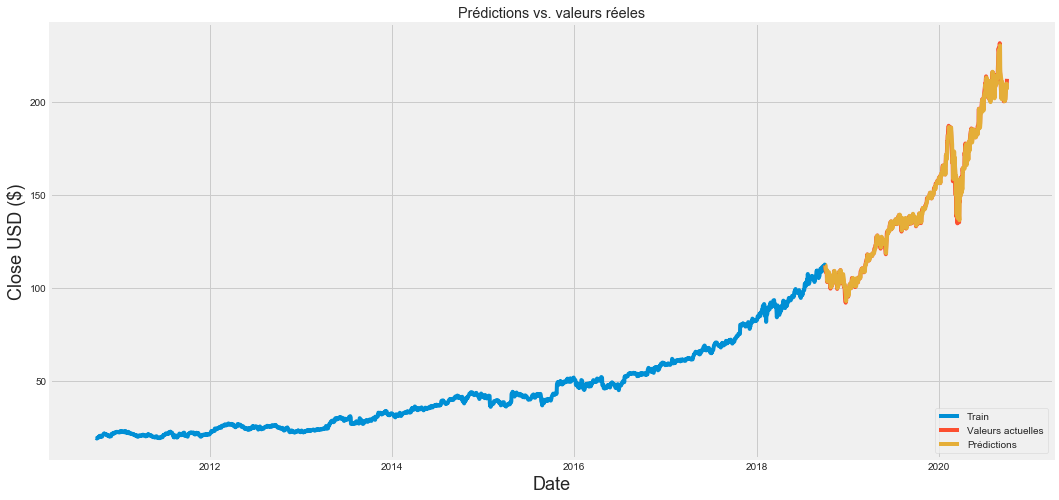

             Close  Predictions
Date                           
2018-10-03  112.11   112.386086
2018-10-04  109.80   112.307404
2018-10-05  109.15   110.111694
2018-10-08  107.91   109.320641
2018-10-09  109.28   108.253555
...            ...          ...
2020-09-25  207.82   203.067795
2020-09-28  209.44   208.130875
2020-09-29  207.26   209.870407
2020-09-30  210.33   207.265793
2020-10-01  212.46   209.987137

[503 rows x 2 columns]


In [10]:
model = algo_lstm(x_train, y_train, x_test, y_test, scaler, "MSFT")

# LSTM Google 

La valeur de notre RMSE est de 3.48 pour Google.

Longueur du data: 2016
Longueur du data: 2016
Epoch 1/50
110/110 [==============================] - ETA: 0s - loss: 5.9230e-04
Epoch 00001: val_loss improved from inf to 0.00012, saving model to GOOG_model.h5
110/110 [==============================] - 8s 75ms/step - loss: 5.9230e-04 - val_loss: 1.2240e-04
Epoch 2/50
110/110 [==============================] - ETA: 0s - loss: 3.0826e-05
Epoch 00002: val_loss improved from 0.00012 to 0.00011, saving model to GOOG_model.h5
110/110 [==============================] - 5s 41ms/step - loss: 3.0826e-05 - val_loss: 1.0502e-04
Epoch 3/50
110/110 [==============================] - ETA: 0s - loss: 3.1348e-05
Epoch 00003: val_loss did not improve from 0.00011
110/110 [==============================] - 5s 49ms/step - loss: 3.1348e-05 - val_loss: 1.5247e-04
Epoch 4/50
110/110 [==============================] - ETA: 0s - loss: 3.2538e-05
Epoch 00004: val_loss improved from 0.00011 to 0.00009, saving model to GOOG_model.h5
110/110 [======================

Epoch 34/50
109/110 [============================>.] - ETA: 0s - loss: 1.3454e-05
Epoch 00034: val_loss did not improve from 0.00004
110/110 [==============================] - 7s 64ms/step - loss: 1.3419e-05 - val_loss: 6.7993e-05
Epoch 35/50
109/110 [============================>.] - ETA: 0s - loss: 1.7820e-05
Epoch 00035: val_loss did not improve from 0.00004
110/110 [==============================] - 5s 49ms/step - loss: 1.7759e-05 - val_loss: 9.2438e-05
Epoch 36/50
110/110 [==============================] - ETA: 0s - loss: 1.1275e-05- ETA: 1s - 
Epoch 00036: val_loss did not improve from 0.00004
110/110 [==============================] - 6s 51ms/step - loss: 1.1275e-05 - val_loss: 1.7258e-04
Epoch 37/50
110/110 [==============================] - ETA: 0s - loss: 1.0992e-05
Epoch 00037: val_loss improved from 0.00004 to 0.00004, saving model to GOOG_model.h5
110/110 [==============================] - 5s 43ms/step - loss: 1.0992e-05 - val_loss: 4.1164e-05
Epoch 38/50
109/110 [========

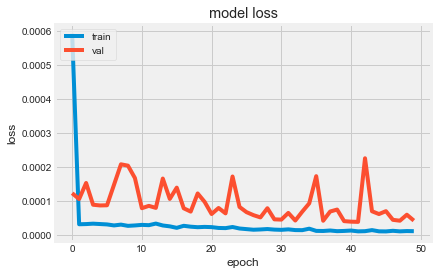

RMSE: 3.6951192121793692


C:\Users\ouizb\anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


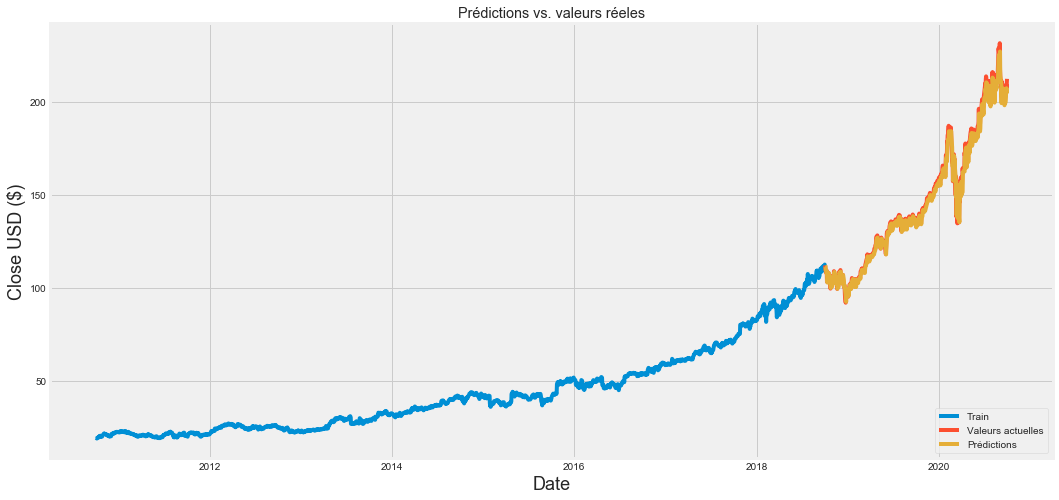

             Close  Predictions
Date                           
2018-10-03  112.11   111.731461
2018-10-04  109.80   111.639198
2018-10-05  109.15   109.568611
2018-10-08  107.91   108.658073
2018-10-09  109.28   107.596115
...            ...          ...
2020-09-25  207.82   200.648117
2020-09-28  209.44   205.381653
2020-09-29  207.26   207.415314
2020-09-30  210.33   205.156204
2020-10-01  212.46   207.381958

[503 rows x 2 columns]


In [11]:
x_train, y_train, x_test, y_test, scaler, data, dataset, training_data_len = split_data(df_concat, "GOOG")
model = algo_lstm(x_train, y_train, x_test, y_test, scaler, "GOOG")

# LSTM Amazon

La valeur de notre RMSE est de 3.43 pour AMazon.

Longueur du data: 2016
Longueur du data: 2016
Epoch 1/50
109/110 [============================>.] - ETA: 0s - loss: 5.9651e-04
Epoch 00001: val_loss improved from inf to 0.00010, saving model to AMZN_model.h5
110/110 [==============================] - 7s 61ms/step - loss: 5.9129e-04 - val_loss: 9.6733e-05
Epoch 2/50
109/110 [============================>.] - ETA: 0s - loss: 3.1032e-05
Epoch 00002: val_loss did not improve from 0.00010
110/110 [==============================] - 5s 45ms/step - loss: 3.1327e-05 - val_loss: 1.0857e-04
Epoch 3/50
110/110 [==============================] - ETA: 0s - loss: 3.3268e-05
Epoch 00003: val_loss did not improve from 0.00010
110/110 [==============================] - 5s 44ms/step - loss: 3.3268e-05 - val_loss: 1.4241e-04
Epoch 4/50
110/110 [==============================] - ETA: 0s - loss: 3.0493e-05
Epoch 00004: val_loss improved from 0.00010 to 0.00009, saving model to AMZN_model.h5
110/110 [==============================] - 6s 53ms/step - loss: 3.

Epoch 34/50
109/110 [============================>.] - ETA: 0s - loss: 1.2095e-05
Epoch 00034: val_loss did not improve from 0.00004
110/110 [==============================] - 5s 43ms/step - loss: 1.2073e-05 - val_loss: 4.5071e-05
Epoch 35/50
110/110 [==============================] - ETA: 0s - loss: 1.1798e-05
Epoch 00035: val_loss improved from 0.00004 to 0.00004, saving model to AMZN_model.h5
110/110 [==============================] - 5s 41ms/step - loss: 1.1798e-05 - val_loss: 3.9918e-05
Epoch 36/50
110/110 [==============================] - ETA: 0s - loss: 1.1186e-05
Epoch 00036: val_loss improved from 0.00004 to 0.00004, saving model to AMZN_model.h5
110/110 [==============================] - 5s 42ms/step - loss: 1.1186e-05 - val_loss: 3.9274e-05
Epoch 37/50
110/110 [==============================] - ETA: 0s - loss: 1.5168e-05
Epoch 00037: val_loss did not improve from 0.00004
110/110 [==============================] - 5s 41ms/step - loss: 1.5168e-05 - val_loss: 6.1008e-05
Epoch 

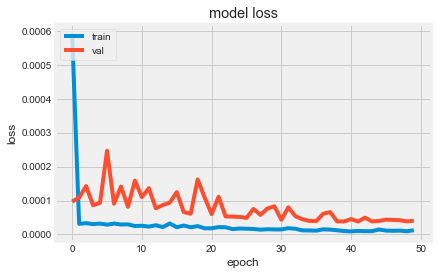

RMSE: 3.4994405153535584


C:\Users\ouizb\anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


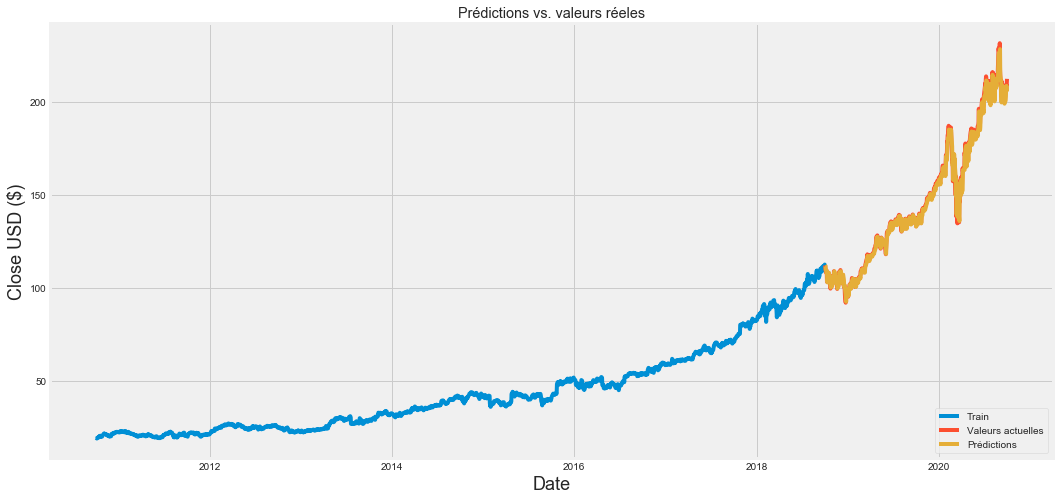

             Close  Predictions
Date                           
2018-10-03  112.11   111.975166
2018-10-04  109.80   111.869537
2018-10-05  109.15   109.788338
2018-10-08  107.91   108.837654
2018-10-09  109.28   107.769646
...            ...          ...
2020-09-25  207.82   201.679840
2020-09-28  209.44   206.686920
2020-09-29  207.26   208.682709
2020-09-30  210.33   206.178497
2020-10-01  212.46   208.565262

[503 rows x 2 columns]


In [12]:
x_train, y_train, x_test, y_test, scaler, data, dataset, training_data_len = split_data(df_concat, "AMZN")
model = algo_lstm(x_train, y_train, x_test, y_test, scaler, "AMZN")

# Pridction du Prix du lendemain (le 29/09/2020)

1. convertir les données en un array qui ne contient que le prix de clôture.
2. Prénons le dernier prix de clôture de 60 jours pour faire la prédiction du 61ème jour.
3. Comparons la valaur prédite à la valeur actuelle sur le marché. 

In [13]:
def predict_price(symbol):
    tickerData = yf.Ticker(symbol)
    df = tickerData.history(period='1d', start='2010-10-1', end="2020-10-3")
    new_df = df.filter(['Close'])
    last_60_days = new_df[-60:].values
    scaler =  MinMaxScaler()

    last_60_days_scaled = scaler.fit_transform(last_60_days)
    X_test = []
    X_test.append(last_60_days_scaled)
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    pred_price = model.predict(X_test)
    pred_price = scaler.inverse_transform(pred_price)
    print(f'Prix prédit: {pred_price}')

    actual_price = tickerData.history(period='1d', start="2020-10-3", end="2020-10-3")
    actual_price = actual_price.Close.values
    actual_price = np.array(actual_price)
    print(f'Prix réel: {actual_price}')
    return pred_price, actual_price

In [14]:
predict_price("MSFT")

Prix prédit: [[207.08533]]
Prix réel: [206.19]


(array([[207.08533]], dtype=float32), array([206.19]))

In [15]:
predict_price("AMZN")

Prix prédit: [[3135.6646]]
Prix réel: [3125.]


(array([[3135.6646]], dtype=float32), array([3125.]))

In [16]:
predict_price("GOOG")

Prix prédit: [[1464.7988]]
Prix réel: [1458.42]


(array([[1464.7988]], dtype=float32), array([1458.42]))

## Conclusion

Les RMSES sont proches de zéro, ce qui signifie que l'écart entre nos valeurs prédites et nos valeurs réelles est faible. 

Nous avons fait la prédiction d'un pas dans l'avenir (le 29/30/2020), après visualisation de nos resultats, notre modèle LSTM est assez bon pour prédir correctement les cours des actions. 